In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
import sys
% matplotlib inline

In [2]:
fname = '200625//200625_Bi2Ye30617_3w_1.txt'
df = pd.read_csv(fname, sep = ' ')


In [3]:
df.head()

,Date_time,Time,TC,SENS,Lockin1f,Lockin2f,X3,Y3,X3_ref,Y3_ref
0,2020-06-25,12:05:36.4154242277.955291748047,15,16,0.0100,0.0099,-0.000122,0.000004,0.000012,-4.768410e-07
1,2020-06-25,12:35:41.6226764083.162543773651,15,16,0.0158,0.0100,-0.000123,0.000006,0.000010,-1.192100e-06
2,2020-06-25,13:05:46.8279285888.366795301437,15,16,0.0251,0.0157,-0.000122,0.000008,0.000010,-7.748640e-07
3,2020-06-25,13:36:12.0503257713.591192483902,15,16,0.0398,0.0337,-0.000121,0.000011,0.000010,-9.536820e-07
4,2020-06-25,14:06:57.2938669558.83373427391,15,16,0.0631,0.0631,-0.000119,0.000016,0.000009,-1.192100e-06


In [4]:
alpha = 0.0048331#temperature coefficient --need remeasure for better accuracy
Re0 = 3.105#resistance at RT
Rref = 3
X1_ref = 0.0572512
I1w = X1_ref / Rref
l = 4.5e-3/2#half length of wire(= half gap width)
width = 2.5e-3; #mm line width --
thickness = 50e-6 #um line thickness --
S = width * thickness  #crosssectional area
rou =  7.74e3#kg/m^3 density
#correction_factor = 1 - 1.5 / (50 + 2.7 + 3.5) # 1 - R_all_3w_parts / R_total

In [5]:
def X3_calc(f1, k, cp, correction_factor = 1):
    w1 = 2 * np.pi * f1
    kappa = k / (rou * cp)
    tau = 4 * l**2 / kappa
    X3 = - alpha * Re0**2 * I1w**3 * l / (12 * k * S) * (1 / (1 + (w1 * tau / 5)**2))
    return X3
def Y3_calc(f1, k, cp, correction_factor = 1):
    w1 = 2 * np.pi * f1
    kappa = k / (rou * cp)
    tau = 4 * l**2 / kappa
    Y3 = alpha * Re0**2 * I1w**3 * l / (12 * k * S) * ((w1 * tau / 5) / (1 + (w1 * tau / 5)**2))
    return Y3
def X3_Y3_fit(fcombo, k, cp):
    X3 = X3_calc(fcombo[:int(len(fcombo) / 2)], k, cp)
    Y3 = Y3_calc(fcombo[int(len(fcombo) / 2):], k, cp)
    return np.concatenate([X3,Y3])

1.5673499999999998

In [6]:
xdata = np.concatenate([df['Lockin1f'], df['Lockin1f']])
ydata = np.concatenate([df['X3'], df['Y3']])
popt, pcov = curve_fit(X3_Y3_fit, xdata, ydata, p0 = [10, 10])

In [7]:
popt,pcov

(array([  4.00565526,  40.07046282]),
 array([[  2.64579196e-04,  -1.06321496e-10],
        [ -1.06321496e-10,   1.93721393e-01]]))

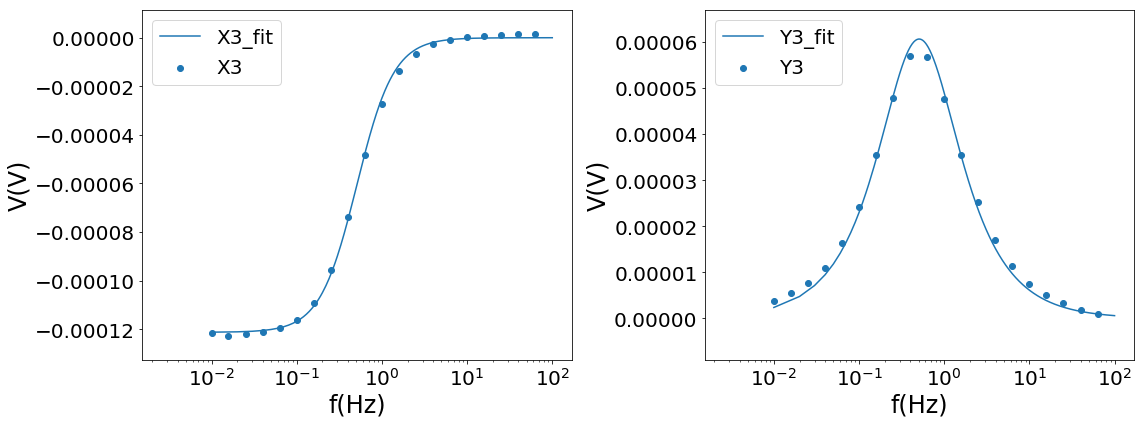

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (16,6))
fz = 24

f1 = np.arange(0.01, 100.01, 0.01)

axs[0].scatter(df.Lockin1f, df.X3, label = 'X3')
#axs[0].scatter(df.Lockin1f, df.X3_ref, label = 'X3_ref')
#axs[0].scatter(df2.Lockin1f, df2.X3, label = 'X3 test2 (measured next day)')
#axs[0].scatter(df2.Lockin1f, df2.X3_ref, label = 'X3_ref test2')
axs[0].plot(f1, X3_calc(f1,*popt), label = 'X3_fit')
axs[0].set_xlabel('f(Hz)', fontsize = fz)
axs[0].set_ylabel('V(V)', fontsize = fz)
axs[0].set_xscale('log')
#axs[0].set_xlim(0.01,1000)
axs[0].legend(loc = 'upper left', fontsize = 20)
axs[0].tick_params(labelsize = 20)
axs[0].set_ylim(df.X3.min() - 10e-6, df.X3.max() + 10e-6)

axs[1].scatter(df.Lockin1f, df.Y3, label = 'Y3')
#axs[1].scatter(df.Lockin1f, df.Y3_ref, label = 'Y3_ref')
#axs[1].scatter(df2.Lockin1f, df2.Y3, label = 'X3 test2')
#axs[1].scatter(df2.Lockin1f, df2.Y3_ref, label = 'X3_ref test2')
axs[1].plot(f1, Y3_calc(f1, *popt), label = 'Y3_fit')
axs[1].set_xlabel('f(Hz)', fontsize = fz)
axs[1].set_ylabel('V(V)', fontsize = fz)
axs[1].set_xscale('log')
#axs[1].set_xlim(0.01,1000)
axs[1].tick_params(labelsize = 20)
axs[1].legend(loc = 'upper left', fontsize = 20)
axs[1].set_ylim(df.Y3.min() - 10e-6, df.Y3.max() + 10e-6)
#axs[1].text(0.6,0.8, f"fitted k = {round(popt[0],2)} W/mK\nfitted cp = {round(popt[1],2)} J/kgK", 
#            fontsize = 14, transform=axs[1].transAxes)

#plt.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.tight_layout()
fig.savefig(fname[:-4] + '_raw.jpg', dpi = 300)

## help(plt.legend)